In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cub-200-2011/CUB_200_2011.tgz


In [3]:
!rm -rf /kaggle/working/*

In [4]:
! ls /kaggle/input/cub-200-2011

CUB_200_2011.tgz


In [5]:
! tar -xvf /kaggle/input/cub-200-2011/CUB_200_2011.tgz

attributes.txt
CUB_200_2011/
CUB_200_2011/images/
CUB_200_2011/images/001.Black_footed_Albatross/
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0010_796097.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0032_796115.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0057_796106.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0036_796127.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0060_796076.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0019_796104.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0069_796139.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0089_796069.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0071_796113.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0077_796114.jpg
CUB_200_2011/images/001.Black_footed_Albat

In [6]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger


2024-08-04 20:32:42.788879: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-04 20:32:42.789008: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-04 20:32:42.926373: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
f = open('/kaggle/working/CUB_200_2011/README', 'r')
print(f.read())

The Caltech-UCSD Birds-200-2011 Dataset

For more information about the dataset, visit the project website:

  http://www.vision.caltech.edu/visipedia

If you use the dataset in a publication, please cite the dataset in
the style described on the dataset website (see url above).

Directory Information
---------------------

- images/
    The images organized in subdirectories based on species. See 
    IMAGES AND CLASS LABELS section below for more info.
- parts/
    15 part locations per image. See PART LOCATIONS section below 
    for more info.
- attributes/
    322 binary attribute labels from MTurk workers. See ATTRIBUTE LABELS 
    section below for more info.



IMAGES AND CLASS LABELS:
Images are contained in the directory images/, with 200 subdirectories (one for each bird species)

------- List of image files (images.txt) ------
The list of image file names is contained in the file images.txt, with each line corresponding to one image:

<image_id> <image_name>
---------------

In [8]:
import os
import numpy as np
import tensorflow as tf
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Total number of images: 11788
Number of training images: 5994
Number of test images: 5794
Number of classes: 200


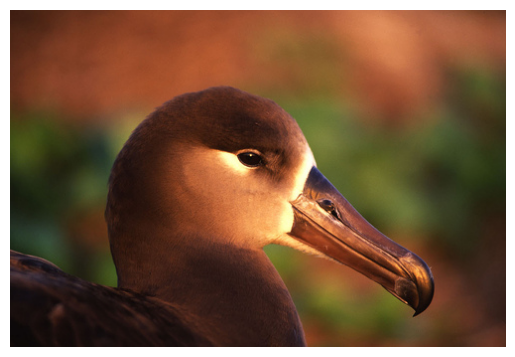

In [9]:
# Set the path to your dataset
data_dir = '/kaggle/working/CUB_200_2011'

# Load image information
images_df = pd.read_csv(os.path.join(data_dir, 'images.txt'), sep=' ', names=['image_id', 'image_name'], index_col='image_id')

# Load train/test split
split_df = pd.read_csv(os.path.join(data_dir, 'train_test_split.txt'), sep=' ', names=['image_id', 'is_training_image'], index_col='image_id')

# Load class labels
labels_df = pd.read_csv(os.path.join(data_dir, 'image_class_labels.txt'), sep=' ', names=['image_id', 'class_id'], index_col='image_id')

#Load bbox
bbox_df = pd.read_csv(os.path.join(data_dir, 'bounding_boxes.txt'), 
                      sep=' ', 
                      names=['image_id', 'x', 'y', 'width', 'height'], 
                      index_col='image_id')

# Merge dataframes
data_df = images_df.join(split_df).join(labels_df).join(bbox_df)

# Print dataset information
print(f"Total number of images: {len(data_df)}")
print(f"Number of training images: {sum(data_df['is_training_image'])}")
print(f"Number of test images: {sum(data_df['is_training_image'] == 0)}")
print(f"Number of classes: {data_df['class_id'].nunique()}")

# Display a sample image
sample_image_path = os.path.join(data_dir, 'images', data_df.iloc[6]['image_name'])
img = plt.imread(sample_image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [10]:
part_locs = pd.read_csv('/kaggle/working/CUB_200_2011/parts/part_locs.txt', sep=' ', names=['image_id', 'part_id', 'part_x', 'part_y', 'visible'])
part_locs_dict = part_locs.groupby('image_id').apply(lambda x: x[['part_id', 'part_x', 'part_y', 'visible']].values.tolist()).to_dict()

/tmp/ipykernel_34/3510944546.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  part_locs_dict = part_locs.groupby('image_id').apply(lambda x: x[['part_id', 'part_x', 'part_y', 'visible']].values.tolist()).to_dict()


In [11]:
data_df.head()

,image_name,is_training_image,class_id,x,y,width,height
image_id,,,,,,,
1,001.Black_footed_Albatross/Black_Footed_Albatr...,0,1,60.0,27.0,325.0,304.0
2,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,139.0,30.0,153.0,264.0
3,001.Black_footed_Albatross/Black_Footed_Albatr...,0,1,14.0,112.0,388.0,186.0
4,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,112.0,90.0,255.0,242.0
5,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,70.0,50.0,134.0,303.0


In [12]:
# Define image size
IMG_SIZE = (224, 224)  # MobileNetV2 default input size

In [13]:
# def augment_image(image):
#     # Ensure the image is in float format
#     image = tf.cast(image, tf.float32)
    
#     # Random flip left-right
#     image = tf.image.random_flip_left_right(image)
    
#     # Random brightness adjustment
#     image = tf.image.random_brightness(image, max_delta=0.2)
    
#     # Random contrast adjustment
#     image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
#     # Random saturation adjustment
#     image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    
#     # Random hue adjustment
#     image = tf.image.random_hue(image, max_delta=0.2)
    
#     # Ensure the image values are still in [0, 1]
# #     image = tf.clip_by_value(image, 0.0, 1.0)
    
#     return image

In [27]:
# def process_image(image_path, label, bbox, is_training=True):
#     try:
#         # Read the image
#         image = tf.io.read_file(image_path)
#         image = tf.image.decode_jpeg(image, channels=3)
        
#         # Get image dimensions
#         shape = tf.shape(image)
#         height = shape[0]
#         width = shape[1]
        
#         # Ensure bbox coordinates are within image dimensions
#         y = tf.maximum(0, tf.cast(bbox[1], tf.int32))
#         x = tf.maximum(0, tf.cast(bbox[0], tf.int32))
#         h = tf.minimum(tf.cast(bbox[3], tf.int32), height - y)
#         w = tf.minimum(tf.cast(bbox[2], tf.int32), width - x)
        
#         # Apply bounding box
#         image = tf.image.crop_to_bounding_box(image, y, x, h, w)
        
#         # Resize the image
#         image = tf.image.resize(image, IMG_SIZE)
        
#         return image, label
#     except tf.errors.InvalidArgumentError:
#         # Return a blank image and the label if there's an error
#         return tf.zeros(IMG_SIZE + (3,), dtype=tf.float32), label+' blank'
    
    
def process_image(image_path, label, bbox, image_id):
    try:
        # Read the image
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        
        # Get image dimensions
        shape = tf.shape(image)
        height = tf.cast(shape[0], tf.float32)
        width = tf.cast(shape[1], tf.float32)
        
        # Ensure bbox coordinates are within image dimensions
        y = tf.maximum(0.0, bbox[1])
        x = tf.maximum(0.0, bbox[0])
        h = tf.minimum(bbox[3], height - y)
        w = tf.minimum(bbox[2], width - x)
        
        # Apply bounding box
        image = tf.image.crop_to_bounding_box(
            image, 
            tf.cast(y, tf.int32), 
            tf.cast(x, tf.int32), 
            tf.cast(h, tf.int32), 
            tf.cast(w, tf.int32)
        )
        
        # Resize the image
        image = tf.image.resize(image, IMG_SIZE)
        
        # Get part locations
        part_locs = part_locs_dict.get(image_id, [])
        part_locs = tf.constant(part_locs, dtype=tf.float32)
        
        # Normalize part locations
        part_locs = part_locs[:, 1:3]  # Keep only x and y
#         part_locs = (part_locs - [x, y]) / [w, h]  # Normalize to [0, 1] within bbox
#         part_locs = tf.clip_by_value(part_locs, 0, 1)  # Ensure values are in [0, 1]
        
        # Pad or truncate to ensure we always have 15 parts
        part_locs = tf.pad(part_locs, [[0, 15 - tf.shape(part_locs)[0]], [0, 0]])[:15]
        
        return image, label, part_locs
    except Exception as e:
        tf.print("Error processing image:", image_path, "Error:", e)
        # Return a blank image, label, and empty part locations if there's an error
        return tf.zeros(IMG_SIZE + (3,), dtype=tf.float32), label, tf.zeros((15, 2), dtype=tf.float32)
    
# Wrap the function to ensure consistent output shapes
def process_image_wrapper(image_path, label, bbox, image_id):
    image, label, part_locs = tf.py_function(
        process_image, 
        [image_path, label, bbox, image_id], 
        [tf.float32, tf.int64, tf.float32]
    )
    image.set_shape(IMG_SIZE + (3,))
    label.set_shape([])
    part_locs.set_shape([15, 2])
    return image, label, part_locs

In [28]:
# def prepare_dataset(dataframe, is_training=True, batch_size=32):
#     image_paths = dataframe['image_name'].apply(lambda x: os.path.join(data_dir, 'images', x)).values
#     labels = dataframe['class_id'].values - 1  # Subtract 1 to make labels 0-indexed
#     bboxes = dataframe[['x', 'y', 'width', 'height']].values

#     dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels, bboxes))
#     dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    
#     # Filter out error cases (blank images)
#     dataset = dataset.filter(lambda x, y: tf.reduce_sum(x) != 0)
    
#     if is_training:
#         dataset = dataset.shuffle(buffer_size=len(dataframe))
        
#     dataset = dataset.repeat()
#     dataset = dataset.batch(batch_size)
#     dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
#     return dataset

def prepare_dataset(dataframe, is_training=True, batch_size=32):
    print(f"Preparing {'training' if is_training else 'testing'} dataset")
    print(f"Dataframe shape: {dataframe.shape}")
    
    image_paths = dataframe['image_name'].apply(lambda x: os.path.join(data_dir, 'images', x)).values
    labels = dataframe['class_id'].values - 1  # Subtract 1 to make labels 0-indexed
    bboxes = dataframe[['x', 'y', 'width', 'height']].values
    image_ids = dataframe.index.values  # Use index as image_id
    
    print(f"Number of images: {len(image_paths)}")
    
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels, bboxes, image_ids))
#     print(dataset)
    dataset = dataset.map(process_image_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
#     print(image_ids)
    
    # Filter out error cases (blank images)
    dataset = dataset.filter(lambda x, y, z: tf.reduce_sum(x) != 0)
    
    if is_training:
        dataset = dataset.shuffle(buffer_size=len(dataframe))
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    # Check if the dataset is empty
    for _ in dataset.take(1):
        print("Dataset contains at least one element")
        break
    else:
        print("Dataset is empty")
    
    return dataset

In [29]:
# Create training and validation datasets
train_df = data_df[data_df['is_training_image'] == 1]
test_df = data_df[data_df['is_training_image'] == 0]

In [30]:
print((train_df.index.values))

[    2     4     5 ... 11782 11784 11787]


In [ ]:
batch_size = 32
train_dataset = prepare_dataset(train_df, is_training=True, batch_size=batch_size)
test_dataset = prepare_dataset(test_df, is_training=False, batch_size=batch_size)

In [239]:
y_test = np.array(test_df['class_id'])
y_test

array([  1,   1,   1, ..., 200, 200, 200])

In [240]:
# Calculate steps per epoch and validation steps
train_samples = len(train_df)
test_samples = len(test_df)
steps_per_epoch = math.ceil(train_samples / batch_size)
validation_steps = math.ceil(test_samples / batch_size)

print(f"Train samples: {train_samples}")
print(f"Test samples: {test_samples}")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

Train samples: 5994
Test samples: 5794
Steps per epoch: 188
Validation steps: 182


In [241]:
train_df.head()

,image_name,is_training_image,class_id,x,y,width,height
image_id,,,,,,,
2,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,139.0,30.0,153.0,264.0
4,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,112.0,90.0,255.0,242.0
5,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,70.0,50.0,134.0,303.0
7,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,7.0,75.0,420.0,262.0
8,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,78.0,86.0,333.0,158.0


In [242]:
# Check if the dataset contains any data
for images, labels, part_locs in train_dataset.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Part locs shape:", part_locs.shape)
    print("Number of images in batch:", len(images))
    break
else:
    print("Dataset is empty!")

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_3_device_/job:localhost/replica:0/task:0/device:CPU:0}} pyfunc_2 returns 0 values, but expects to see 3 values.
	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 

In [243]:
# # Visualize a batch of processed images
# plt.figure(figsize=(10, 10))
# for images, labels in train_dataset.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
# #         print(images[i].numpy())
#         plt.imshow((images[i].numpy())/255)  # Rescale to [0, 1] for visualization
#         plt.title(f"Class {labels[i].numpy()}")
#         plt.axis("off")
# plt.show()

# Visualize a batch of processed images
plt.figure(figsize=(10, 10))
for images, labels, part_locs in train_dataset.take(1):
    for i in range(9):
        print(images[i].numpy())
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy())  # No need to rescale if your process_image function already outputs values in [0, 1]
#         plt.title(f"Class {labels[i].numpy()}")
#         plt.axis("off")
        
#         # Optionally, you can visualize part locations
#         part_locs_img = part_locs[i].numpy()
#         plt.scatter(part_locs_img[:, 0] * 224, part_locs_img[:, 1] * 224, c='r', s=20)  # Assuming IMG_SIZE is (224, 224)

# plt.show()

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_3_device_/job:localhost/replica:0/task:0/device:CPU:0}} pyfunc_2 returns 0 values, but expects to see 3 values.
	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 

<Figure size 1000x1000 with 0 Axes>

In [133]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [134]:
input_shape = IMG_SIZE+(3,)

In [135]:
num_classes = len(np.unique(y_test, equal_nan=False))

# Base model from pre-trained MobileNetV2
# base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')

# # Freeze the base model
# base_model.trainable = False

In [136]:
class CustomAugment(tf.keras.layers.Layer):
    def __init__(self, brightness_delta=0.2, contrast_range=(0.8, 1.2),
                 saturation_range=(0.8, 1.2), hue_delta=0.1, **kwargs):
        super(CustomAugment, self).__init__(**kwargs)
        self.brightness_delta = brightness_delta
        self.contrast_range = contrast_range
        self.saturation_range = saturation_range
        self.hue_delta = hue_delta

    def call(self, inputs, training=None):
        def augment(images):
            images = tf.image.random_flip_left_right(images)
            images = tf.image.random_brightness(images, self.brightness_delta)
            images = tf.image.random_contrast(images, self.contrast_range[0], self.contrast_range[1])
            images = tf.image.random_saturation(images, self.saturation_range[0], self.saturation_range[1])
            images = tf.image.random_hue(images, self.hue_delta)
            return images

        return tf.cond(tf.constant(training, dtype=tf.bool),
                       lambda: augment(inputs),
                       lambda: inputs)

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super(CustomAugment, self).get_config()
        config.update({
            'brightness_delta': self.brightness_delta,
            'contrast_range': self.contrast_range,
            'saturation_range': self.saturation_range,
            'hue_delta': self.hue_delta,
        })
        return config
    
    

In [ ]:
class PartExtractor(layers.Layer):
    def __init__(self, num_parts, part_size=(64, 64), **kwargs):
        super(PartExtractor, self).__init__(**kwargs)
        self.num_parts = num_parts
        self.part_size = part_size

    def call(self, inputs):
        image, part_locs = inputs
        parts = []
        for i in range(self.num_parts):
            x, y = part_locs[:, i, 0], part_locs[:, i, 1]
            part = tf.image.crop_and_resize(
                image, 
                boxes=tf.stack([y-32/224, x-32/224, y+32/224, x+32/224], axis=1),
                box_indices=tf.range(tf.shape(image)[0]),
                crop_size=self.part_size
            )
            parts.append(part)
        return parts

In [ ]:
def create_part_based_model(input_shape, num_classes, num_parts=15, base_trainable=False):
    # Create the base model
    base_model = EfficientNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    
    # Set the base model to be trainable or not
    base_model.trainable = base_trainable

    # Main image processing branch
    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Part locations processing branch
    part_input = layers.Input(shape=(num_parts, 2))
    part_features = layers.Dense(64, activation='relu')(part_input)
    part_features = layers.Flatten()(part_features)

    # Combine both branches
    combined = layers.Concatenate()([x, part_features])
    outputs = layers.Dense(num_classes, activation='softmax')(combined)

    # Create the final model
    model = models.Model(inputs=[inputs, part_input], outputs=outputs)

    return model

# Create the model
model = create_part_based_model(input_shape=IMG_SIZE + (3,), num_classes=200, base_trainable=False)

In [137]:
# Defining the model
# model = models.Sequential([
#     layers.Input(shape=input_shape),
#     CustomAugment(),
#     layers.Lambda(preprocess_input),
#     base_model,
#     layers.GlobalAveragePooling2D(),
#     layers.Dense(1024, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(512, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(num_classes, activation='softmax')
# ])

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ custom_augment_5                │ (None, 224, 224, 3)    │             0 │
│ (CustomAugment)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_5 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 200)            │       102,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,197,128 (16.01 MB)

 Trainable params: 1,939,144 (7.40 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [138]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [139]:
# Learning rate schedule
def lr_schedule(epoch):
    initial_lr = 0.001
    if epoch < 10:
        return initial_lr
    elif epoch < 20:
        return initial_lr * 0.1
    else:
        return initial_lr * 0.01

In [140]:
# Callbacks
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3)

In [141]:
# callbacks list
callbacks = [
    early_stopping,
    reduce_lr,
    checkpoint,
    lr_scheduler
]

In [142]:
try:
    history = model.fit(
        train_dataset,
        epochs=50,
        validation_data=test_dataset,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=callbacks
    )
except Exception as e:
    print(f"An error occurred during training: {str(e)}")
    raise

Epoch 1/50
  5/188 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.0191 - loss: 5.6801     

W0000 00:00:1722791910.155866     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.0222 - loss: 5.3133

W0000 00:00:1722791922.481849     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.16415, saving model to best_model.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 109ms/step - accuracy: 0.0223 - loss: 5.3094 - val_accuracy: 0.1641 - val_loss: 3.7417 - learning_rate: 0.0010
Epoch 2/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.1153 - loss: 3.8771
Epoch 2: val_accuracy improved from 0.16415 to 0.31799, saving model to best_model.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.1155 - loss: 3.8751 - val_accuracy: 0.3180 - val_loss: 2.7401 - learning_rate: 0.0010
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2251 - loss: 3.0947
Epoch 3: val_accuracy improved from 0.31799 to 0.41380, saving model to best_model.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.2252 - loss: 3.0944 - val_accuracy: 0.4138 - val_loss: 2.2341 - learning_rate: 0.0010
Epoch 4/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2997 - loss: 2.7123
Epoch 4: val_accuracy improved from 0.41380 

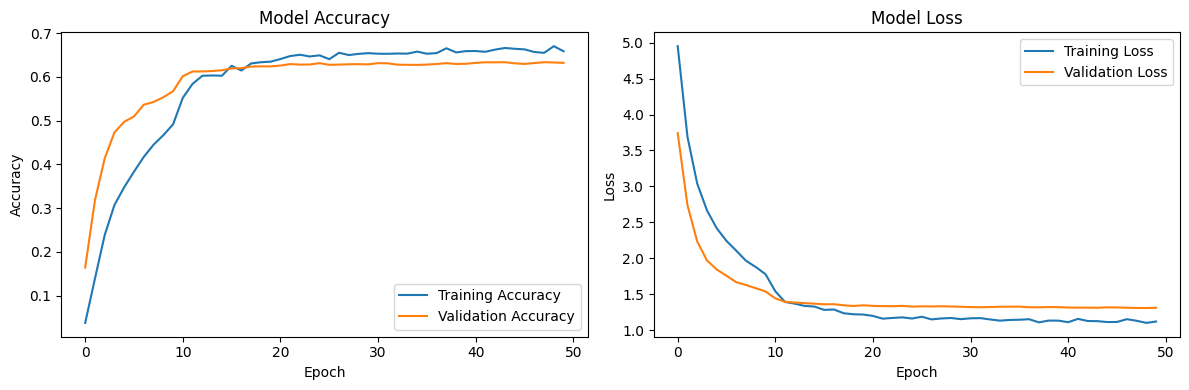

In [143]:
# Training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [144]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_dataset, steps=validation_steps)
print(f"Test accuracy: {test_accuracy:.4f}")

182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.6589 - loss: 1.2043
Test accuracy: 0.6320


In [145]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

  5/182 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step

W0000 00:00:1722792687.033529     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


182/182 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step


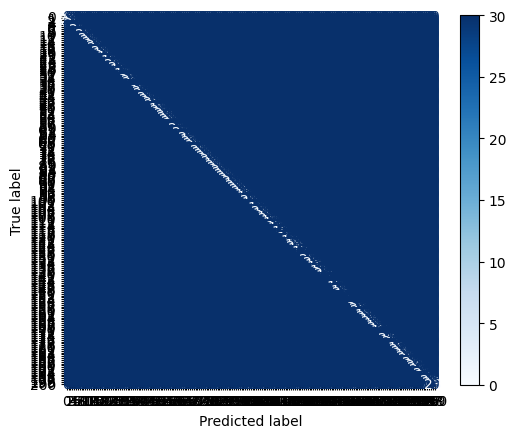

In [146]:
y_pred = model.predict(test_dataset, steps=validation_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Computing the confusion matrix
# Had to index y_pred_classes as test_dataset is an infinite dataset, and the predictions are for all the
# images accessed in the specified steps
cm = confusion_matrix(y_test, y_pred_classes[:5794])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

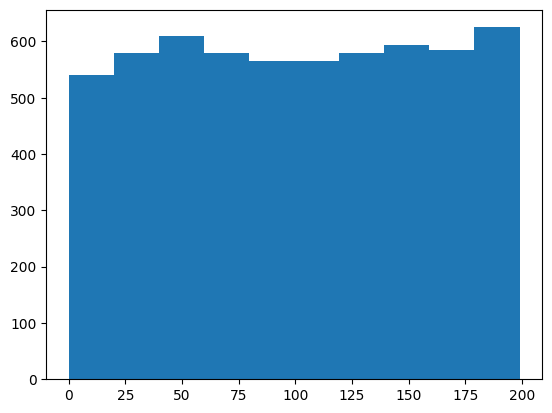

In [147]:
plt.hist(y_pred_classes)
plt.show()

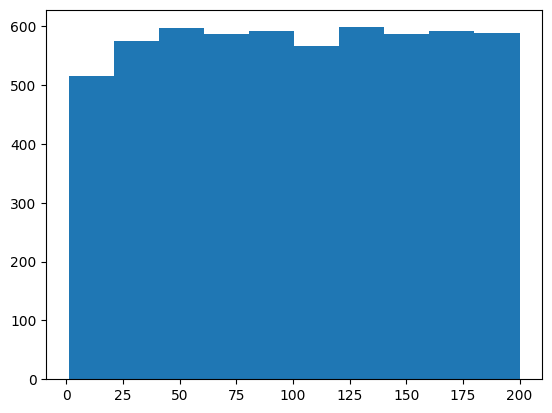

In [148]:
plt.hist(y_test)
plt.show()